# **LSTM PARAMETER TUNNING:**
In this notebook we will run two models:

##### - LSTM2: ADDED LSTM LAYER AND DROPOUT LAYER, 320 BATCH, 35 iteraciones
##### - LSTM3: trying to adjusti parameters of previous model

### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, RepeatVector, TimeDistributed, LSTM, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-Spanish sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-Spanish pairs separated by '\n' and then split these pairs into English sentences and Spanish sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "spa.txt" in your working directory.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/Analisis Datos no Estructurados/Practicas NLP

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Analisis Datos no Estructurados/Practicas NLP


In [0]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)[:,0:2] #NOS QUEDAMOS SOLO CON LAS PRIMERAS COLUMNAS QUE TIENEN LA INFORMACION

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
#PARA ENTRENAR EL PRIMER MODELO VOY A USARLAS TODAS ASI QUE COMENTO ESTA LINEA
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [7]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.'],
       ['I appreciate your interest.', 'Agradezco tu interés.']],
      dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

#### *IMPORTANTE QUITAR LA EXCLAMACION HACIA ARRIBA PARA EL ESPAÑOL



In [0]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

## TAMBIEN QUITAMOS ESTA EXCLAMACION QUE LO ANTERIOR NO LO QUITA
spa_eng[:,0] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,1]]

In [9]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda'],
       ['I appreciate your interest', 'Agradezco tu interés']],
      dtype='<U332')

In [0]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [11]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer'],
       ['i appreciate all your help', 'aprecio toda tu ayuda'],
       ['i appreciate your interest', 'agradezco tu interés']],
      dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and Spanish, respectively.

In [0]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


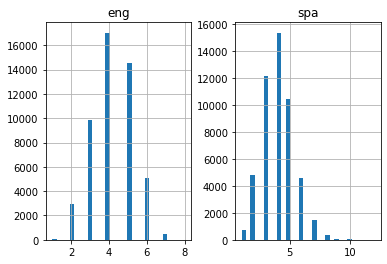

In [14]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the Spanish sentences is 12 and that of the English phrases is 8.


Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [17]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 13937


In [18]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 118), ('vete', 42), ('vaya', 46), ('váyase', 7), ('hola', 21), ('corre', 19), ('corran', 2), ('corra', 1), ('corred', 2), ('¿quién', 380), ('órale', 10), ('fuego', 37), ('incendio', 5), ('disparad', 3), ('ayuda', 184), ('socorro', 2), ('auxilio', 3), ('salta', 4), ('salte', 2), ('parad', 2), ('para', 547), ('pare', 6), ('espera', 65), ('esperen', 10), ('continúa', 15), ('continúe', 7), ('corrí', 13), ('corría', 4), ('lo', 2126), ('intento', 8), ('he', 428), ('ganado', 16), ('oh', 8), ('no', 5964), ('tomátelo', 2), ('con', 871), ('soda', 3), ('disparen', 1), ('dispara', 1), ('dispará', 1), ('dispare', 3), ('sonríe', 5), ('al', 576), ('ataque', 6), ('atacad', 1), ('ataquen', 1), ('ataca', 1), ('levanta', 23), ('ahora', 489), ('mismo', 129), ('id', 6), ('vayan', 11), ('ya', 340), ('tengo', 878), ('¿lo', 63), ('pillas', 1), ('¿entendiste', 2), ('él', 2564), ('corrió', 23), ('métete', 5), ('adentro', 26), ('abrázame', 1), ('me', 3040), ('caí', 6), ('yo', 1183), ('sé', 43

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode Spanish sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4805    4    6 ...    0    0    0]
 [  14 4930    0 ...    0    0    0]
 ...
 [  43  198 1663 ...    0    0    0]
 [  18   12   15 ...    8 1195    0]
 [   2  241 1477 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [22]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [23]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   30 ...    0    0    0]
 [ 235    4    1 ...    0    0    0]
 [ 107 8429    0 ...    0    0    0]
 ...
 [9404  115  975 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   32 6681 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [24]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [0]:
# build NMT model (LSTM)
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [26]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

13937
6942
8
8


In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            7135744   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 512)           

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [29]:
filename = 'modelLSTM2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=35, batch_size=320, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/35
32000/32000 [==============================] - 24s 745us/step - loss: 3.7068 - val_loss: 3.3149

Epoch 00001: val_loss improved from inf to 3.31491, saving model to modelCuDNNLSTM.h1
Epoch 2/35
32000/32000 [==============================] - 21s 661us/step - loss: 3.1762 - val_loss: 3.0864

Epoch 00002: val_loss improved from 3.31491 to 3.08640, saving model to modelCuDNNLSTM.h1
Epoch 3/35
32000/32000 [==============================] - 21s 663us/step - loss: 2.9915 - val_loss: 2.9963

Epoch 00003: val_loss improved from 3.08640 to 2.99628, saving model to modelCuDNNLSTM.h1
Epoch 4/35
32000/32000 [==============================] - 21s 664us/step - loss: 2.8513 - val_loss: 2.9064

Epoch 00004: val_loss improved from 2.99628 to 2.90640, saving model to modelCuDNNLSTM.h1
Epoch 5/35
32000/32000 [==============================] - 21s 662us/step - loss: 2.7155 - val_loss: 2.7628

Epoch 00005: val_loss improved from 2.90640 to 2.76279,

Let's compare the training loss and the validation loss.

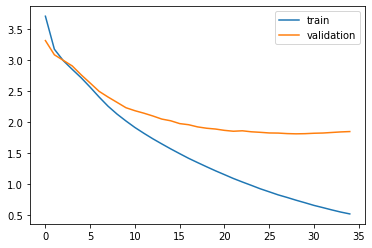

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [31]:
model = load_model('modelLSTM2.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'Spanish':  test[:,1], 'actual traduction' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [42]:
pred_df.head(15)

,Spanish,actual traduction,predicted
0,ellos son muy optimistas,they are very cheerful,theyre very
1,conozco a tom,i know tom,i know tom
2,puedes negarte,you may refuse,you may
3,eso es privado,thats private,thats dangerous
4,tom saltó desde su asiento,tom leaped from his seat,tom finished with his
5,¿jamás has vendido un auto,have you ever sold a car,did you ever a car
6,¿cuántos hijos tienes,how many kids do you have,how many kids do you have
7,no te dejaré hacerlo,i will not let you do it,i wont let you
8,¿no es hermoso,isnt it beautiful,isnt it beautiful
9,mi loro murió ayer,my parrot died yesterday,my computer was back


This model is worse than our base model. We get a higher error and worse translations. Lets try to adjust some parameters:

## MODEL 2

- Since it seems to be learning slowly we reduce the dropout
- We will run more epochs with a lower learning rate to avoid over-fitting
- We will increase the batch size

In [47]:
# build NMT model (LSTM)
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.0007)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8, 512)            7135744   
_________________________________________________________________
lstm_10 (LSTM)               (None, 8, 512)            2099200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 8, 512)            2099200   
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 512)           

In [49]:
filename = 'modelLSTM3.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=50, batch_size=400, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/50
32000/32000 [==============================] - 20s 631us/step - loss: 0.3604 - val_loss: 1.8956

Epoch 00001: val_loss improved from inf to 1.89556, saving model to modelLSTM3.h1
Epoch 2/50
32000/32000 [==============================] - 20s 629us/step - loss: 0.3406 - val_loss: 1.8877

Epoch 00002: val_loss improved from 1.89556 to 1.88772, saving model to modelLSTM3.h1
Epoch 3/50
32000/32000 [==============================] - 20s 629us/step - loss: 0.3217 - val_loss: 1.8947

Epoch 00003: val_loss did not improve from 1.88772
Epoch 4/50
32000/32000 [==============================] - 20s 628us/step - loss: 0.3058 - val_loss: 1.8955

Epoch 00004: val_loss did not improve from 1.88772
Epoch 5/50
32000/32000 [==============================] - 20s 625us/step - loss: 0.2882 - val_loss: 1.9031

Epoch 00005: val_loss did not improve from 1.88772
Epoch 6/50
32000/32000 [==============================] - 20s 627us/step - loss: 0.2714 - 

In [50]:
model = load_model('modelLSTM3.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df['predicted_LSTM3'] = preds_text
pred_df = pred_df.rename(columns={"predicted": "predicted_LSTM2"}) 

In [53]:
pred_df.head(10)

,Spanish,actual traduction,predicted_LSTM2,predicted_LSTM3
0,ellos son muy optimistas,they are very cheerful,theyre very,they very
1,conozco a tom,i know tom,i know tom,i know tom
2,puedes negarte,you may refuse,you may,you can prove
3,eso es privado,thats private,thats dangerous,thats is
4,tom saltó desde su asiento,tom leaped from his seat,tom finished with his,tom works on his seat
5,¿jamás has vendido un auto,have you ever sold a car,did you ever a car,have you look a car
6,¿cuántos hijos tienes,how many kids do you have,how many kids do you have,how many do you have
7,no te dejaré hacerlo,i will not let you do it,i wont let you,i wont not you
8,¿no es hermoso,isnt it beautiful,isnt it beautiful,isnt it no
9,mi loro murió ayer,my parrot died yesterday,my computer was back,my mother died here


In [54]:
pred_df.tail(10)

,Spanish,actual traduction,predicted_LSTM2,predicted_LSTM3
9990,quiero a su hija,i love your daughter,i want your opinion,i want his son
9991,él da clases de inglés,he teaches english,he speaks to english,he feels for to
9992,me quedé dormido,i overslept,i was asleep,i fell asleep
9993,él es pobre como pocos,he is as poor as can be,he is like to a,he is as
9994,¿dónde está mi camisa,wheres my shirt,wheres your wife,wheres my son
9995,¿todo está bien aquí,is everything ok here,is everything here,is it right here
9996,me cansé de jugar esto,im sick of this game,im laugh at this,im fed of for fish
9997,deshágase del arma,get rid of the gun,get out of the,get took the gun
9998,¿viste esta película,did you watch this movie,did you seen this movie,did you see this movie
9999,no tengo malicia hacia él,i bear him no malice,i dont no to,i have no to


As we can see this models arw worse than our intitial mode LSTM1. They are too complex and do not reach great results. Moreover, LSTM3 is even worse than LSTM2. In the next notebook we will increase the input data to see if we can compensate the complexity of these models.